In [1]:
# matplotlib notebook
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os
import openpyxl
from scipy import stats

In [2]:
datadir = '/scr/tvr/darchr'
plotdir = '/scr/tvr/darchr/notebooks/images/SPEC2006/'
# datadir = '/run/user/1000/gvfs/sftp:host=amarillo.cs.ucdavis.edu/home/tamarnat/VRG-experiments/results/microbench/'

In [3]:
# SPEC2006 benchmarks that could compile with gem5
all_spec2006_benchmarks = ['401.bzip2', '403.gcc', '410.bwaves', '416.gamess', '429.mcf', '433.milc', '434.zeusmp', 
                       '435.gromacs', '436.cactusADM', '437.leslie3d', '444.namd', '445.gobmk', '453.povray', 
                       '454.calculix', '456.hmmer', '458.sjeng', '459.GemsFDTD', '462.libquantum', '464.h264ref', 
                       '465.tonto', '470.lbm', '471.omnetpp', '473.astar', '481.wrf', '482.sphinx3', '998.specrand', 
                       '999.specrand']
spec2006_benchmarks = all_spec2006_benchmarks.copy()
# remove benchmarks that failed
spec2006_benchmarks.remove('434.zeusmp')
spec2006_benchmarks.remove('453.povray')

In [4]:
# SPEC2017 benchmarks that could compile with gem5
all_spec2017_benchmarks = ['500.perlbench_r', '502.gcc_r', '503.bwaves_r', '505.mcf_r', '507.cactuBSSN_r', '508.namd_r', 
                       '510.parest_r', '511.povray_r', '519.lbm_r', '520.omnetpp_r', '521.wrf_r', '523.xalancbmk_r', 
                       '525.x264_r', '526.blender_r', '527.cam4_r', '531.deepsjeng_r', '538.imagick_r', '541.leela_r', 
                       '544.nab_r', '548.exchange2_r', '549.fotonik3d_r', '554.roms_r', '557.xz_r', '600.perlbench_s', 
                       '602.gcc_s', '603.bwaves_s', '605.mcf_s', '607.cactuBSSN_s', '619.lbm_s', '620.omnetpp_s', '621.wrf_s', 
                       '623.xalancbmk_s', '625.x264_s', '627.cam4_s', '628.pop2_s', '631.deepsjeng_s', '638.imagick_s', 
                       '641.leela_s', '644.nab_s', '648.exchange2_s', '649.fotonik3d_s', '654.roms_s', '657.xz_s', 
                       '996.specrand_fs', '997.specrand_fr', '998.specrand_is', '999.specrand_ir']
spec2017_benchmarks = all_spec2017_benchmarks.copy()
spec2017_benchmarks.remove('503.bwaves_r')
spec2017_benchmarks.remove('525.x264_r')
spec2017_benchmarks.remove('527.cam4_r')
spec2017_benchmarks.remove('603.bwaves_s')
spec2017_benchmarks.remove('625.x264_s')

In [5]:
cpus = ['kvm', 'atomic', 'timing', 'o3']
input_sizes = ['test', 'ref']
gem5_versions = ['gem5-19', 'gem5-20.0.0.0', 'gem5-dev']


In [6]:
# function to extract stats
def gem5GetStat(filename, stat):
    filename = os.path.join(datadir, '', filename, 'stats.txt').replace('\\','/')
    try:
        with open(filename) as f:
            r = f.read()
            if len(r) < 10: return 0.0
            start = r.find(stat) + len(stat) + 1
            end = r.find('#', start)
            return float(r[start:end])
    except:
        return 0.0

In [7]:
def makeDF (stat):
    df = pd.DataFrame()
    df['benchmarks'] = benchmarks
    for i in range(1,6):
        arr = []
        cdir = f'{datadir}/spec2006-experiments/results/test/{i}/kvm/test/'
        for bm in spec2006_benchmarks:
            arr.append(gem5GetStat(cdir + bm, stat))
        df[f'{i}'] = arr
    return df            

In [8]:

rows = []
for ver in gem5_versions:
    for cpu in cpus:
        for size in input_sizes:
            cdir = f'{datadir}/spec2006-experiments/results/{ver}/{cpu}/{size}/'
            for bm in spec2006_benchmarks:
                rows.append([ver, cpu, size, bm,
                                    gem5GetStat(cdir + bm, 'sim_seconds'),
                                    gem5GetStat(cdir + bm, 'sim_insts'),
                                    gem5GetStat(cdir + bm, 'sim_ops'),
                                    gem5GetStat(cdir + bm, 'sim_ticks')/1e12,
                                    gem5GetStat(cdir + bm, 'host_seconds'),
                                    gem5GetStat(cdir + bm, 'host_inst_rate')])
spec2006_df = pd.DataFrame(rows, columns=['gem5-ver', 'cpu','data_size', 'benchmark', 'cycles', 'instructions', 'ops', 'sim_seconds', 'host_seconds','host_inst_rate'])
spec2006_df['cpi'] = spec2006_df['cycles']/spec2006_df['instructions']

In [9]:

rows = []
for ver in ['gem5-dev']:
    for cpu in cpus:
        for size in input_sizes:
            cdir = f'{datadir}/spec2017-experiment/results/{cpu}/{size}/'
            for bm in spec2017_benchmarks:
                rows.append([ver, cpu, size, bm,
                                    gem5GetStat(cdir + bm, 'sim_seconds'),
                                    gem5GetStat(cdir + bm, 'sim_insts'),
                                    gem5GetStat(cdir + bm, 'sim_ops'),
                                    gem5GetStat(cdir + bm, 'sim_ticks')/1e12,
                                    gem5GetStat(cdir + bm, 'host_seconds'),
                                    gem5GetStat(cdir + bm, 'host_inst_rate')])

spec2017_df = pd.DataFrame(rows, columns=['gem5-ver', 'cpu', 'data_size', 'benchmark', 'cycles', 'instructions', 'ops', 'sim_seconds', 'host_seconds', 'host_inst_rate'])
spec2017_df['cpi'] = spec2017_df['cycles']/spec2017_df['instructions']


In [10]:
def getArr(ver, cpu, size, benchmarks, stat, df):
    # if opt == 'spec2006': df = spec2006_df
    # elif opt == 'spec2017': df = spec2017_df
    arr = []
    for bench in benchmarks:
        a = df[(df['gem5-ver']==ver) & (df['cpu']==cpu) & (df['data_size']==size) & (df['benchmark']==bench)]
        arr.append(a[stat].iloc[0])
    return arr

In [11]:
def getDF(ver, cpu_list, size, benchmarks, stat, df):
    n_df = pd.DataFrame()
    n_df['benchmarks'] = benchmarks
    for cpu in cpu_list:
        n_df[f'{cpu}_{stat}'] = getArr(ver, cpu, size, benchmarks, stat, df)
    return n_df

In [12]:
# def errRate(avg, val):
#     return pow((avg - val),2)

def errRate(avg, val):
    return float(((avg-val)/avg)*100)

In [13]:
# def rms(stat,bms,df, opt='avg'):

#     sum = 0
#     for bm in bms:
#         d = df[(df['benchmarks']==bm)]
#         sum += d[stat].iloc[0]
#     if (opt == 'rms'): return round(pow((sum/len(bms)),0.5),2)
#     else: 
#         return round((sum/len(bms)),2)

def rms(stat,bms,df,opt='avg'):

    sum = 0
    for bm in bms:
        d = df[(df['benchmarks']==bm)]
        sum +=  abs(d[stat].iloc[0])
    # print(f'{sum}/{len(bms)}')
    return round((sum/len(bms)),2)

In [14]:
benchmarks = spec2006_benchmarks
spec2006_htime_gv20 = getDF('gem5-20.0.0.0', cpus, 'test', benchmarks, 'host_seconds', spec2006_df)
# print(spec2006_htime_gv20)
# Ratio of host time 
# Atomic and KVM
spec2006_htime_gv20['atomic/kvm'] = spec2006_htime_gv20['atomic_host_seconds']/spec2006_htime_gv20['kvm_host_seconds']
# rms of these ratios
rms_atomic_kvm_ratio = rms('atomic/kvm', benchmarks, spec2006_htime_gv20)
err_atomic_kvm = []

# Timing W.R.T KVM and Atomic   
spec2006_htime_gv20['timing/kvm'] = spec2006_htime_gv20['timing_host_seconds']/spec2006_htime_gv20['kvm_host_seconds']
spec2006_htime_gv20['timing/atomic'] = spec2006_htime_gv20['timing_host_seconds']/spec2006_htime_gv20['atomic_host_seconds']
rms_timing_kvm_ratio = rms('timing/kvm', benchmarks, spec2006_htime_gv20)
rms_timing_atomic_ratio = rms('timing/atomic', benchmarks, spec2006_htime_gv20)
err_timing_kvm = []
err_timing_atomic = [] 

# O3 W.R.T others
spec2006_htime_gv20['o3/kvm'] = spec2006_htime_gv20['o3_host_seconds']/spec2006_htime_gv20['kvm_host_seconds']
spec2006_htime_gv20['o3/atomic'] = spec2006_htime_gv20['o3_host_seconds']/spec2006_htime_gv20['atomic_host_seconds']
spec2006_htime_gv20['o3/timing'] = spec2006_htime_gv20['o3_host_seconds']/spec2006_htime_gv20['timing_host_seconds']
rms_o3_kvm_ratio = rms('o3/kvm', benchmarks, spec2006_htime_gv20)
rms_o3_atomic_ratio = rms('o3/atomic', benchmarks, spec2006_htime_gv20)
rms_o3_timing_ratio = rms('o3/timing', benchmarks, spec2006_htime_gv20)
err_o3_kvm = []
err_o3_atomic = [] 
err_o3_timing = []

for bm in benchmarks:
    b = spec2006_htime_gv20[(spec2006_htime_gv20['benchmarks']==bm)]
    err_atomic_kvm.append(errRate(rms_atomic_kvm_ratio, b['atomic/kvm'].iloc[0]))
    err_timing_kvm.append(errRate(rms_timing_kvm_ratio, b['timing/kvm'].iloc[0]))
    err_timing_atomic.append(errRate(rms_timing_atomic_ratio, b['timing/atomic'].iloc[0]))
    err_o3_kvm.append(errRate(rms_o3_kvm_ratio, b['o3/kvm'].iloc[0]))
    err_o3_atomic.append(errRate(rms_o3_atomic_ratio, b['o3/atomic'].iloc[0]))
    err_o3_timing.append(errRate(rms_o3_timing_ratio, b['o3/timing'].iloc[0]))

spec2006_htime_gv20['err_atomic/kvm'] = err_atomic_kvm
spec2006_htime_gv20['err_timing/kvm'] = err_timing_kvm
spec2006_htime_gv20['err_timing/atomic'] = err_timing_atomic
spec2006_htime_gv20['err_o3/kvm'] = err_o3_kvm
spec2006_htime_gv20['err_o3/atomic'] = err_o3_atomic
spec2006_htime_gv20['err_o3/timing'] = err_o3_timing

rms_err_atomic_kvm = rms('err_atomic/kvm', benchmarks, spec2006_htime_gv20,'rms')
rms_err_timing_kvm = rms('err_timing/kvm', benchmarks, spec2006_htime_gv20,'rms')
rms_err_timing_atomic = rms('err_timing/atomic', benchmarks, spec2006_htime_gv20,'rms')
rms_err_o3_kvm = rms('err_o3/kvm', benchmarks, spec2006_htime_gv20,'rms')
rms_err_o3_atomic = rms('err_o3/atomic', benchmarks, spec2006_htime_gv20,'rms')
rms_err_o3_timing = rms('err_o3/timing', benchmarks, spec2006_htime_gv20,'rms')
# print(rms_atomic_kvm_ratio)
# print(rms_timing_kvm_ratio)
# print(rms_timing_atomic_ratio)
# print(rms_o3_kvm_ratio)
# print(rms_o3_atomic_ratio)
# print(rms_o3_timing_ratio)
# print('******************')
# print(rms_err_atomic_kvm)
# print(rms_err_timing_kvm)
# print(rms_err_timing_atomic)
# print(rms_err_o3_kvm)
# print(rms_err_o3_atomic)
# print(rms_err_o3_timing)
# print('****************')
# print(err_atomic_kvm)
# print(spec2006_htime_gv20)

In [15]:
def doplot(ver, cpus, size, benchmarks, stat, df, title):
    x = getArr(ver, cpus[0], size, benchmarks, stat, df)
    y = getArr(ver, cpus[1], size, benchmarks, stat, df)
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    print("slope: %f   intercept: %f   Correlation Coeff: %f   p_value: %f   std_err: %f" % (slope, intercept, r_value, p_value, std_err))
    z = []
    for i in range(len(x)):
        z.append(slope*x[i])
    plt.plot(x, y, 'o', label='original data')
    plt.plot(x, intercept + z, 'r', label='fitted line')
    plt.title(title)
    plt.ylabel(f'{cpus[1]} {stat}')
    plt.xlabel(f'{cpus[0]} {stat}')
    plt.legend()
    plt.show()

## Variation in KVM host time for spec2006, data based on 5 iterations

In [16]:
df = makeDF('host_seconds')
avg = []
for bm in spec2006_benchmarks:
    a = df[df['benchmarks']==bm]
    sum = 0
    for i in range(1,6):
        sum += a[f'{i}'].iloc[0]
    avg.append(sum/5)
err = []
for j,bm in enumerate(spec2006_benchmarks):
    a = df[df['benchmarks']==bm]
    sum = 0
    for i in range(1,6):
        sum += abs((a[f'{i}'].iloc[0] - avg[j])/avg[j])
    err.append(round(sum/5,2)*100)
df['% err'] = err
sum = 0
for i in range(len(err)):
    sum += err[i]
err_avg = sum/len(err)
print(f'Average varation in the host time = (+/-) {err_avg} %')


Average varation in the host time = (+/-) 3.16 %


## Using data from KVM runs to correlate with data from other CPUs
## SPEC2006

slope: 3159.352297   intercept: 1037.361213   Correlation Coeff: 0.842316   p_value: 0.000000   std_err: 421.536364


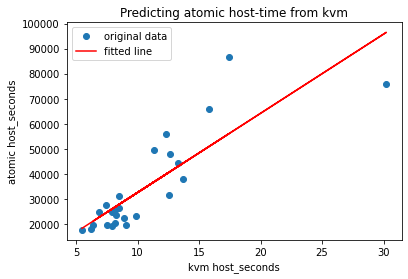

In [17]:
cpu_list = ['kvm', 'atomic']
doplot('gem5-20.0.0.0', cpu_list, 'test', benchmarks, 'host_seconds', spec2006_df, 'Predicting atomic host-time from kvm')

slope: 4893.902659   intercept: 3555.278480   Correlation Coeff: 0.825757   p_value: 0.000000   std_err: 697.009723


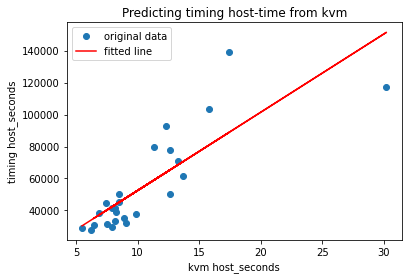

In [18]:
cpu_list = ['kvm', 'timing']
doplot('gem5-20.0.0.0', cpu_list, 'test', benchmarks, 'host_seconds', spec2006_df, 'Predicting timing host-time from kvm')

slope: 1.578149   intercept: 945.085428   Correlation Coeff: 0.998775   p_value: 0.000000   std_err: 0.016301


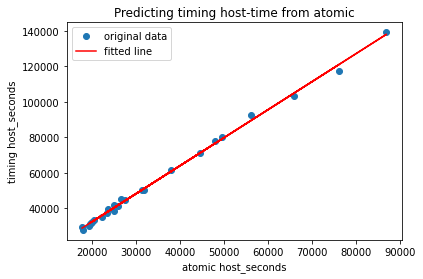

In [19]:
cpu_list = ['atomic', 'timing']
doplot('gem5-20.0.0.0', cpu_list, 'test', benchmarks, 'host_seconds', spec2006_df, 'Predicting timing host-time from atomic')

slope: 25103.877544   intercept: 18119.263650   Correlation Coeff: 0.964313   p_value: 0.000000   std_err: 1437.199507


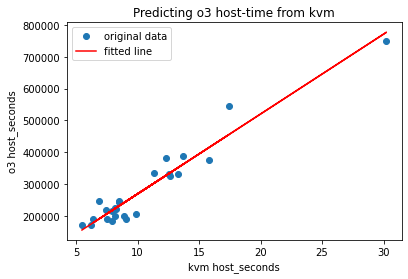

In [20]:
cpu_list = ['kvm', 'o3']
doplot('gem5-20.0.0.0', cpu_list, 'test', benchmarks, 'host_seconds', spec2006_df, 'Predicting o3 host-time from kvm')

slope: 6.293069   intercept: 66806.982042   Correlation Coeff: 0.906698   p_value: 0.000000   std_err: 0.610409


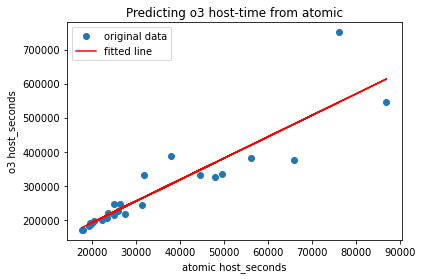

In [21]:
cpu_list = ['atomic', 'o3']
doplot('gem5-20.0.0.0', cpu_list, 'test', benchmarks, 'host_seconds', spec2006_df, 'Predicting o3 host-time from atomic')

slope: 3.937062   intercept: 65834.744192   Correlation Coeff: 0.896299   p_value: 0.000000   std_err: 0.406163


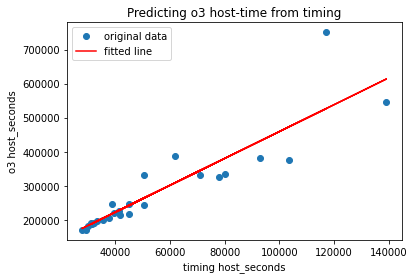

In [22]:
cpu_list = ['timing', 'o3']
doplot('gem5-20.0.0.0', cpu_list, 'test', benchmarks, 'host_seconds', spec2006_df, 'Predicting o3 host-time from timing')

## Correlation between total instructuctions executed in KVM and O#

slope: 1.000812   intercept: 42764686.340363   Correlation Coeff: 0.999999   p_value: 0.000000   std_err: 0.000286


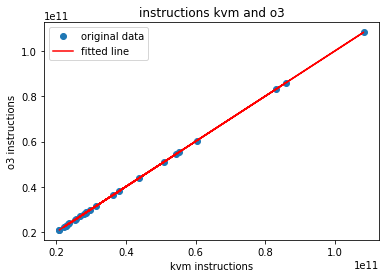

In [23]:
cpu_list = ['kvm', 'o3']
doplot('gem5-20.0.0.0', cpu_list, 'test', benchmarks, 'instructions', spec2006_df, 'instructions kvm and o3')

## Correlation between O3 host seconds and number of instructions executed in KVM mode

slope: 153702.402690   intercept: -3674389294.875999   Correlation Coeff: 0.883718   p_value: 0.000000   std_err: 16973.315603


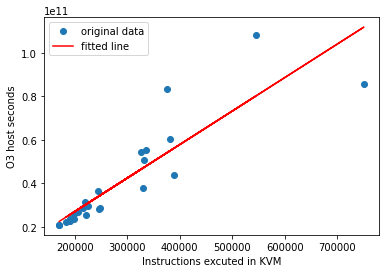

In [24]:
x = getArr('gem5-20.0.0.0', 'o3', 'test', spec2006_benchmarks, 'host_seconds', spec2006_df)
y = getArr('gem5-20.0.0.0', 'kvm', 'test', spec2006_benchmarks, 'instructions', spec2006_df)
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print("slope: %f   intercept: %f   Correlation Coeff: %f   p_value: %f   std_err: %f" % (slope, intercept, r_value, p_value, std_err))
z = []
for i in range(len(x)):
    z.append(slope*x[i])
plt.plot(x, y, 'o', label='original data')
plt.plot(x, intercept + z, 'r', label='fitted line')
plt.ylabel('O3 host seconds')
plt.xlabel('Instructions excuted in KVM')
plt.legend()
plt.show()

## Correlation between O3 host instruction rate and number of instructions executed in KVM mode

slope: 608066.369735   intercept: -43300832645.332146   Correlation Coeff: 0.721575   p_value: 0.000047   std_err: 121653.099621


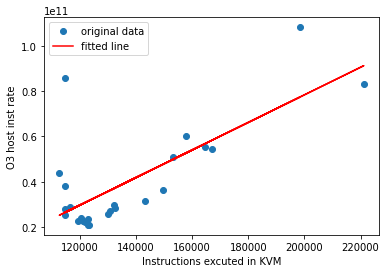

In [25]:
x = getArr('gem5-20.0.0.0', 'o3', 'test', spec2006_benchmarks, 'host_inst_rate', spec2006_df)
y = getArr('gem5-20.0.0.0', 'kvm', 'test', spec2006_benchmarks, 'instructions', spec2006_df)
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print("slope: %f   intercept: %f   Correlation Coeff: %f   p_value: %f   std_err: %f" % (slope, intercept, r_value, p_value, std_err))
z = []
for i in range(len(x)):
    z.append(slope*x[i])
plt.plot(x, y, 'o', label='original data')
plt.plot(x, intercept + z, 'r', label='fitted line')
plt.ylabel('O3 host inst rate')
plt.xlabel('Instructions excuted in KVM')
plt.legend()
plt.show()

## Using KVM runs with ref inputs to correlate with other cpu runs with test inputs  

slope: 293.969545   intercept: 170137.752028   Correlation Coeff: 0.469445   p_value: 0.017907   std_err: 115.290983


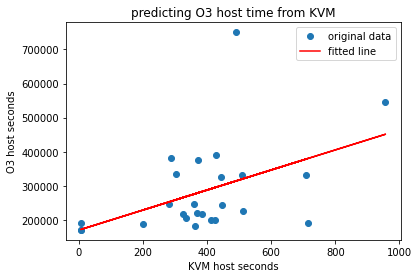

In [26]:
x = getArr('gem5-20.0.0.0', 'kvm', 'ref', spec2006_benchmarks, 'host_seconds', spec2006_df)
y = getArr('gem5-20.0.0.0', 'o3', 'test', spec2006_benchmarks, 'host_seconds', spec2006_df)
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print("slope: %f   intercept: %f   Correlation Coeff: %f   p_value: %f   std_err: %f" % (slope, intercept, r_value, p_value, std_err))
z = []
for i in range(len(x)):
    z.append(slope*x[i])
plt.plot(x, y, 'o', label='original data')
plt.plot(x, intercept + z, 'r', label='fitted line')
plt.title('predicting O3 host time from KVM')
plt.ylabel('O3 host seconds')
plt.xlabel('KVM host seconds')
plt.legend()
plt.show()

## Correlation results for SPEC2017
### note: Currently we do not have enough data to correalte with O3 CPU

slope: 4744.962798   intercept: -5021.631647   Correlation Coeff: 0.862077   p_value: 0.000000   std_err: 441.036628


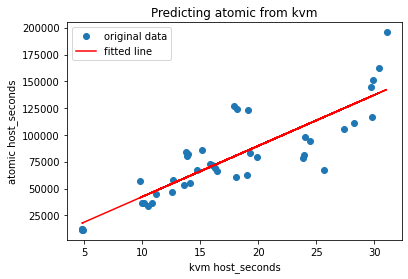

In [27]:
cpu_list = ['kvm', 'atomic']
doplot('gem5-dev', cpu_list, 'test', spec2017_benchmarks, 'host_seconds', spec2017_df, 'Predicting atomic from kvm')

slope: 6222.787239   intercept: -10550.044411   Correlation Coeff: 0.914491   p_value: 0.000000   std_err: 435.319482


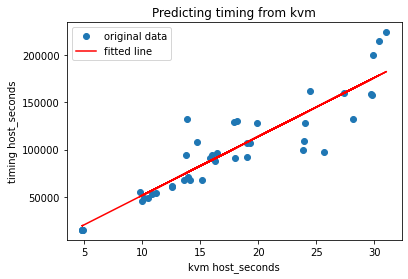

In [28]:
cpu_list = ['kvm', 'timing']
doplot('gem5-dev', cpu_list, 'test', spec2017_benchmarks, 'host_seconds', spec2017_df, 'Predicting timing from kvm')

slope: 1.156041   intercept: 8073.751729   Correlation Coeff: 0.935093   p_value: 0.000000   std_err: 0.069277


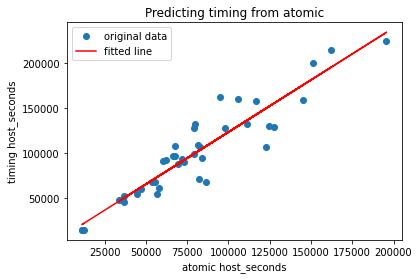

In [29]:
cpu_list = ['atomic', 'timing']
doplot('gem5-dev', cpu_list, 'test', spec2017_benchmarks, 'host_seconds', spec2017_df, 'Predicting timing from atomic')